# GRCh38 DNase 12 kb Optimizer Search 3

**Tasks:** binary cross-entropy loss leads to reliable training

**Insights:**

- 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
testing = False
    
# The base directory is one level up
base = '..'
name = 'optimizer-search-3'
dataset = 'cnn-search'
settings_filepath = '../settings-grch38-chip-12kb.json'
search_filepath = '../{}.json'.format(name)

with open(settings_filepath, "r") as f:
    settings = json.load(f)

with open(search_filepath, "r") as f:
    search = json.load(f)

## Create training jobs

In [2]:
from jobs import jobs

jobs(
    os.path.relpath(search_filepath, base),
    os.path.relpath(settings_filepath, base),
    dataset=dataset,
    name=name,
    cluster='cox',
    epochs=40,
    batch_size=256,
    repeat=10,
    base=base,
    clear=True,
    verbose=False
)


Created slurm file for training 3 neural networks


## Test training run of the most complex CAE

In [ ]:
from train import train_on_single_dataset

with open(os.path.join(base, 'definitions-{}.json'.format(name)), 'r') as f:
    definitions = json.load(f)

train_on_single_dataset(
    settings,
    dataset,
    definitions=definitions,
    definition_idx=1,
    epochs=2,
    batch_size=2048,
    base=base,
    clear=True,
)

In [3]:
from ae.utils import check_status

okay, not_found, outdated = check_status(
    name, 'training', 'cnn-search', base=base
)

if okay:
    print('Trainings completed')
else:
    print('Trainings did not finish. Missing {}'.format(len(not_found)))

Trainings completed


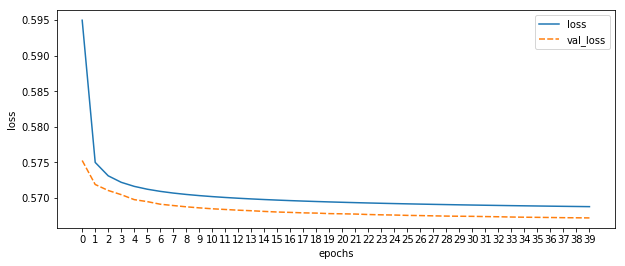

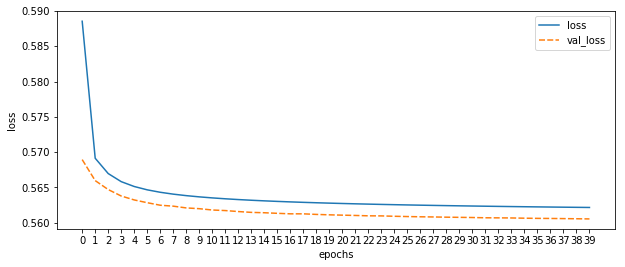

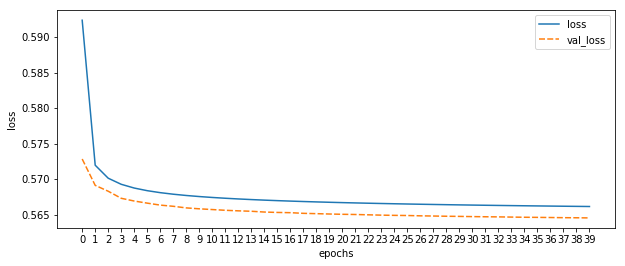

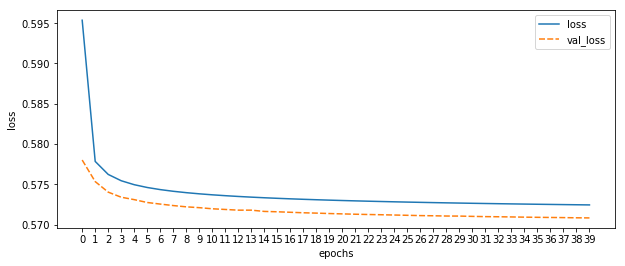

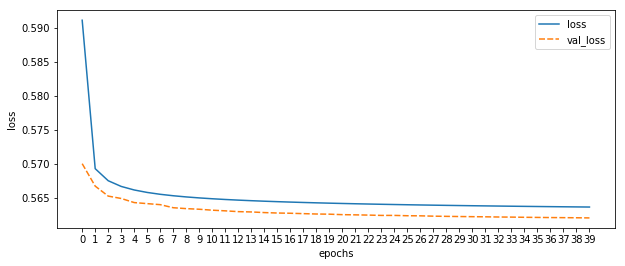

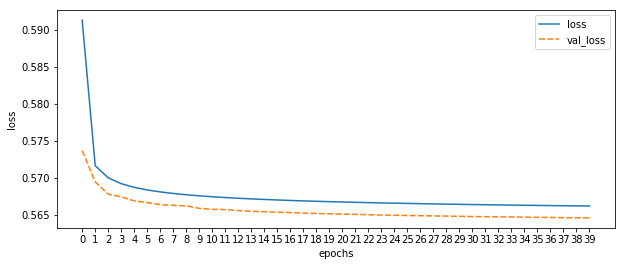

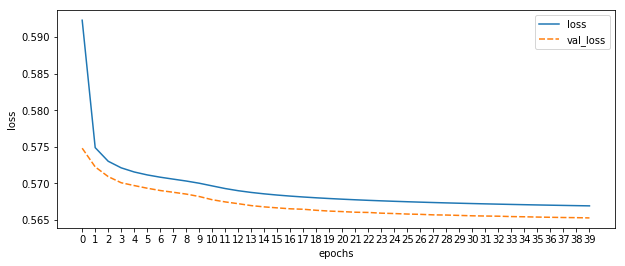

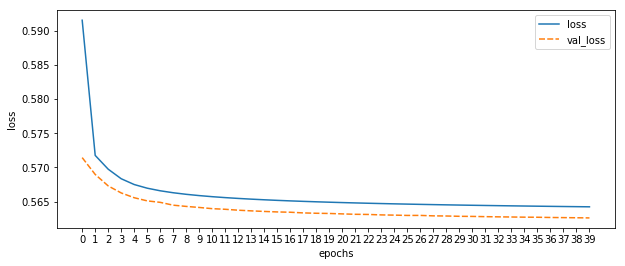

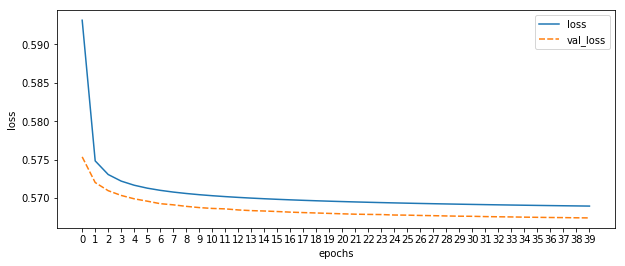

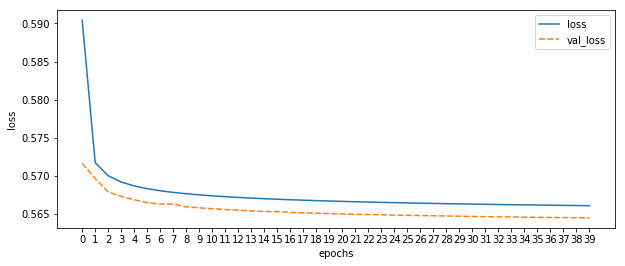

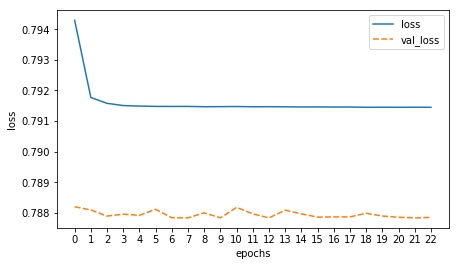

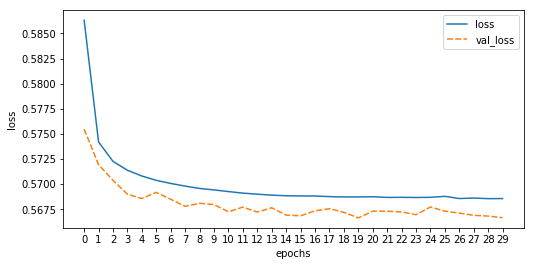

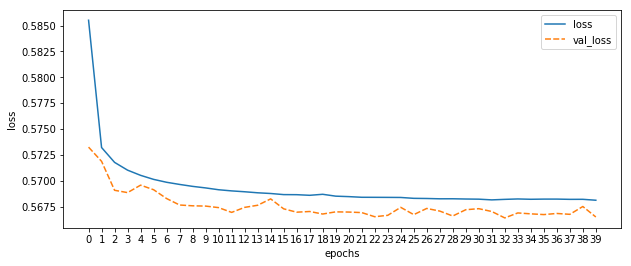

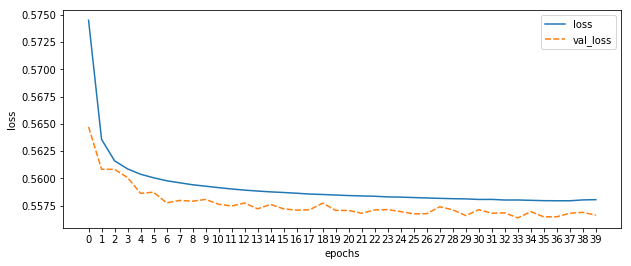

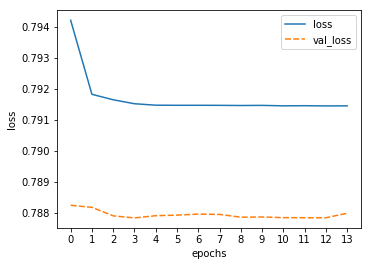

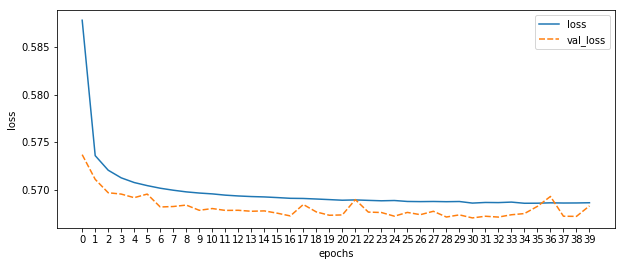

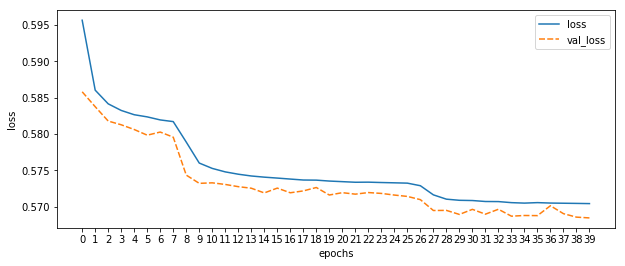

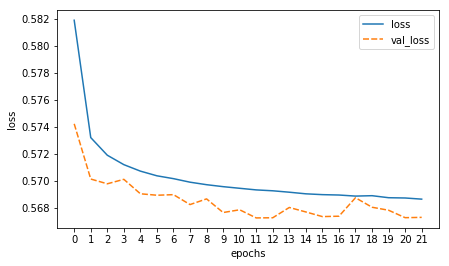

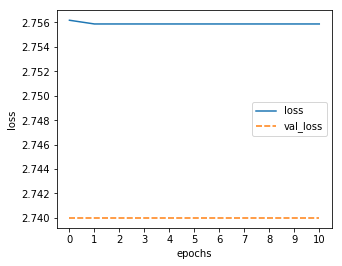

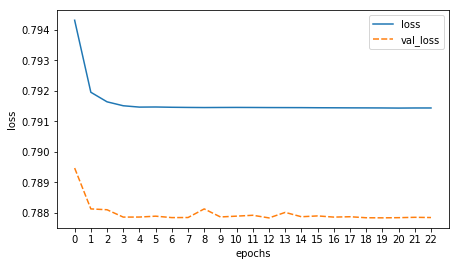

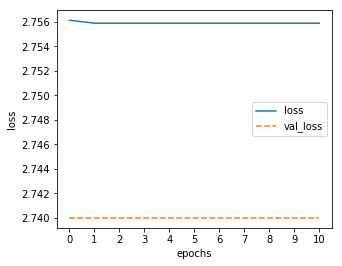

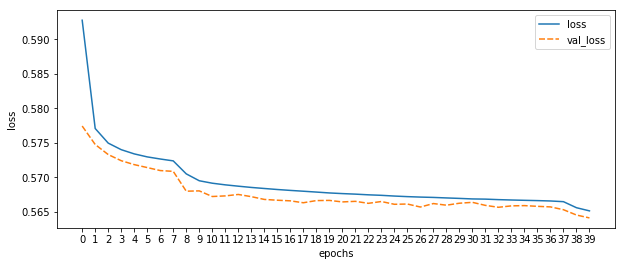

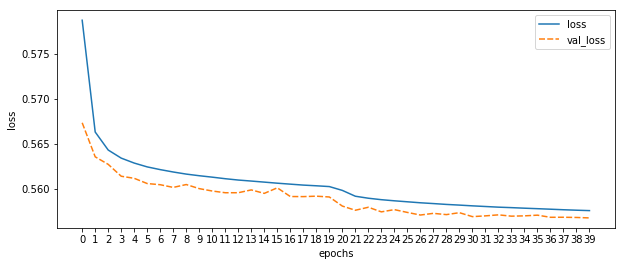

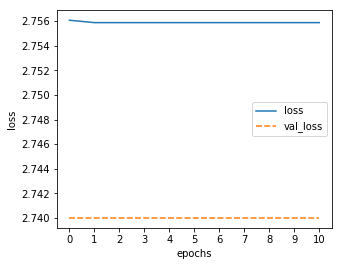

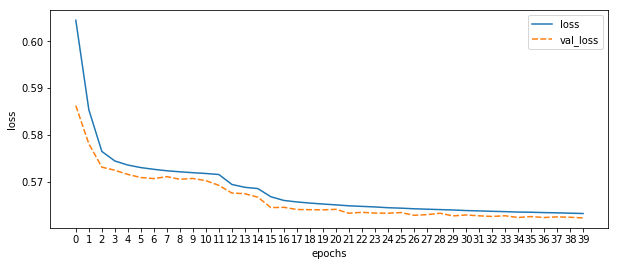

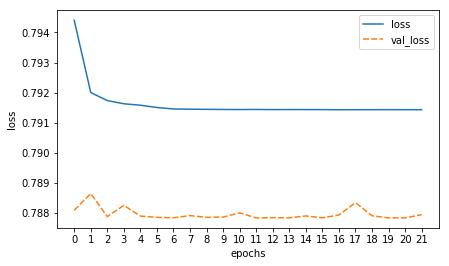

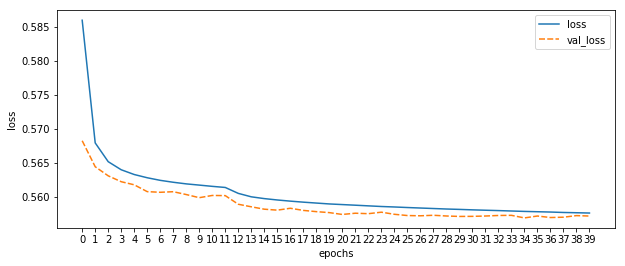

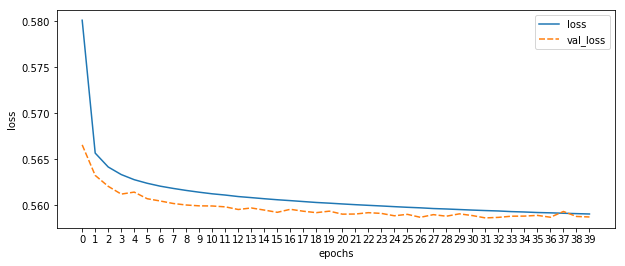

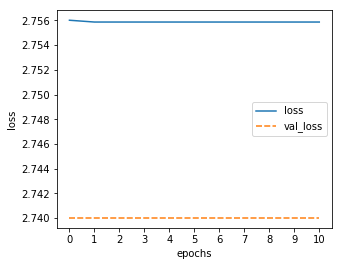

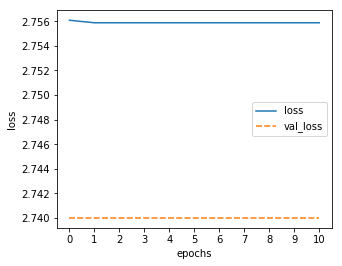

In [24]:
import h5py
from train import plot_loss_to_file

with open(os.path.join(base, 'definitions-{}.json'.format(name)), 'r') as f:
    definitions = json.load(f)
    
for model_name in definitions:
    repetition = None
    if len(model_name.split("__")) > 1:
        model_name, repetition = model_name.split("__")
        
    postfix = "__{}".format(repetition) if repetition is not None else ""
    
    with h5py.File(
        os.path.join(
            base, "models", "{}---training-{}{}.h5".format(model_name, dataset, postfix)
        ),
        "r",
    ) as f:
        loss = f["loss"][:]
        val_loss = f["val_loss"]
        plot_loss_to_file(
            loss, val_loss, model_name, repetition=repetition, dataset_name=dataset, base=base
        )

## Create evaluation jobs

In [15]:
from evaluate import create_jobs

create_jobs(
    name,
    name=name,
    dataset=dataset,
    cluster='cox',
    base=base,
    clear=False,
    incl_dtw=False,
)

Created slurm file for evaluating 30 neural networks


In a terminal run: `sbatch evaluate-optimizer-search-3.slurm`

In [26]:
from ae.utils import check_status

okay, not_found, outdated = check_status(
    name, 'evaluation', dataset, base=base
)

if okay:
    print('Evaluation completed')
else:
    print('Evaluation did not finish. Missing {}'.format(len(not_found)))

Evaluation completed


## Compare

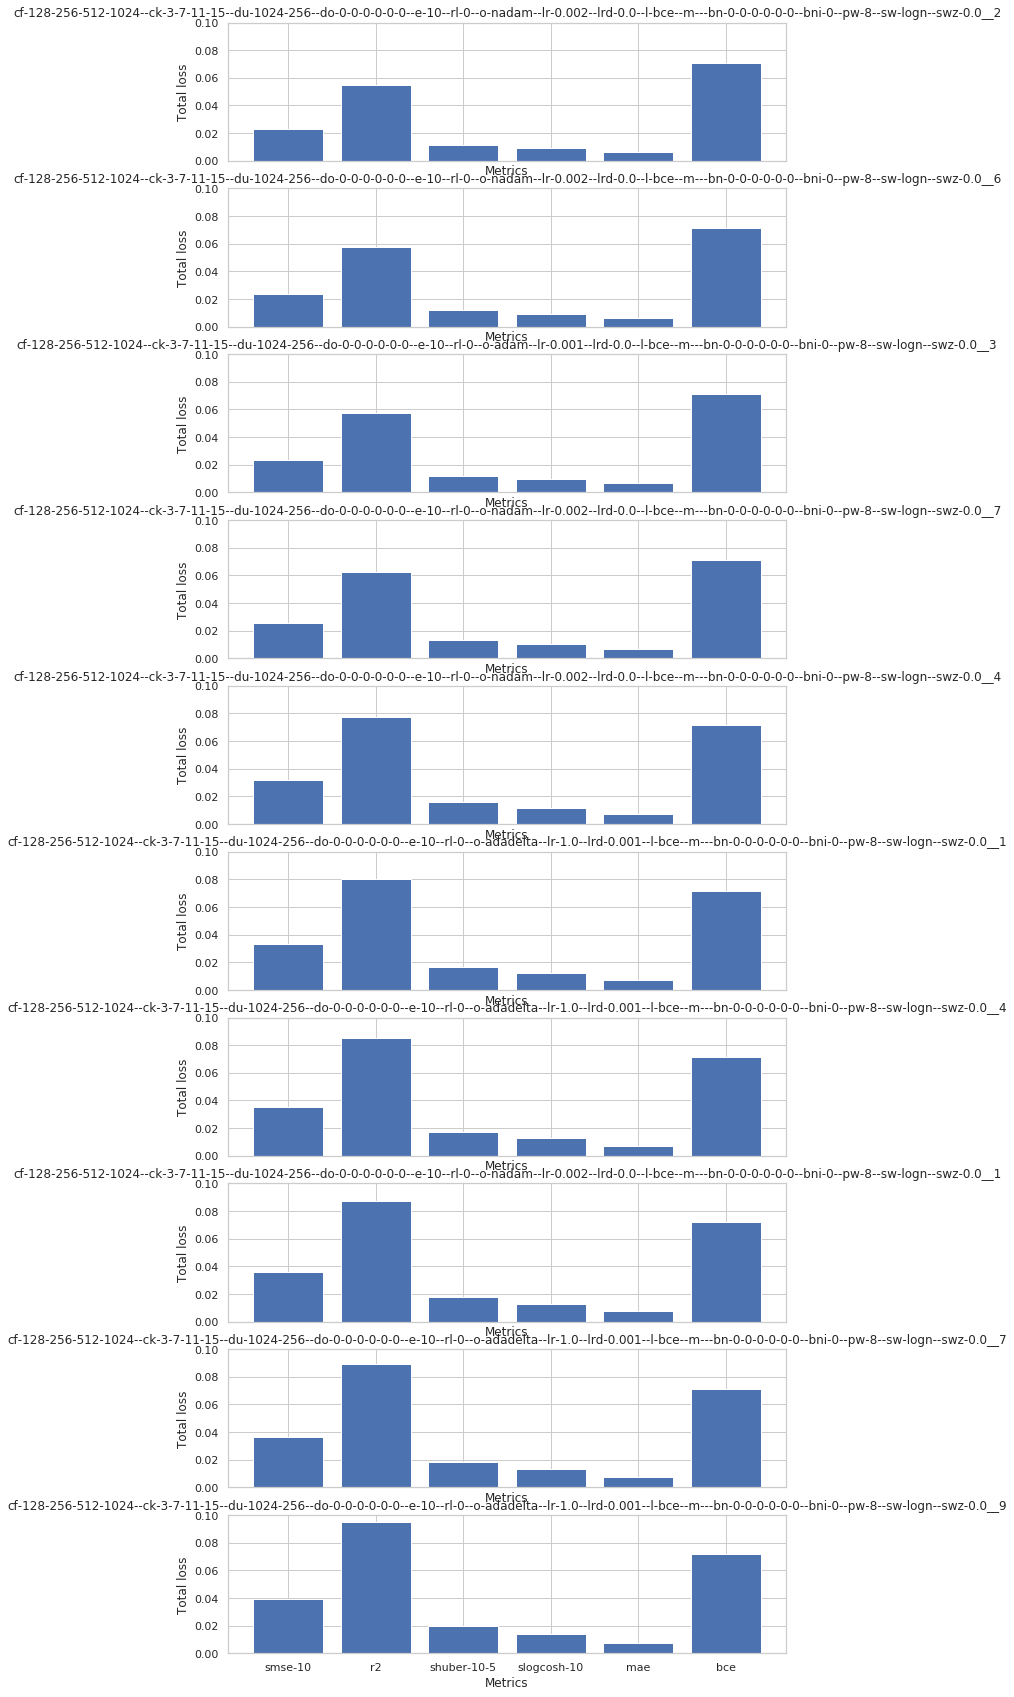

In [27]:
from compare import compare
    
performance = compare(
    'definitions-{}.json'.format(name),
    dataset_name=dataset,
    base=base,
    clear=False,
    verbose=False,
    silent=False,
    remove_common_prefix_from_df=True,
)

In [28]:
import qgrid

qgw = qgrid.show_grid(performance)
qgw

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [46]:
adadelta_r2 = []
adadelta_bce = []
adam_r2 = []
adam_bce = []
nadam_r2 = []
nadam_bce = []

for model in qgw.get_changed_df().iterrows():
    if model[0][:4] == "adad":
        adadelta_r2.append(model[1]['r2'])
        adadelta_bce.append(model[1]['bce'])
    if model[0][:4] == "adam":
        adam_r2.append(model[1]['r2'])
        adam_bce.append(model[1]['bce'])
    if model[0][0] == "n":
        nadam_r2.append(model[1]['r2'])
        nadam_bce.append(model[1]['bce'])
        
print(
    np.array(adadelta_r2).mean(),
    np.array(adadelta_bce).mean(),
    np.array(adam_r2).mean(),
    np.array(adam_bce).mean(),
    np.array(nadam_r2).mean(),
    np.array(nadam_bce).mean(),
)

0.09746289625763893 0.07175987276651315 0.09304367937147617 0.0718547472789389 0.06782738789916039 0.0712067783344795


nadam--lr-0.002--lrd-0.0--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0


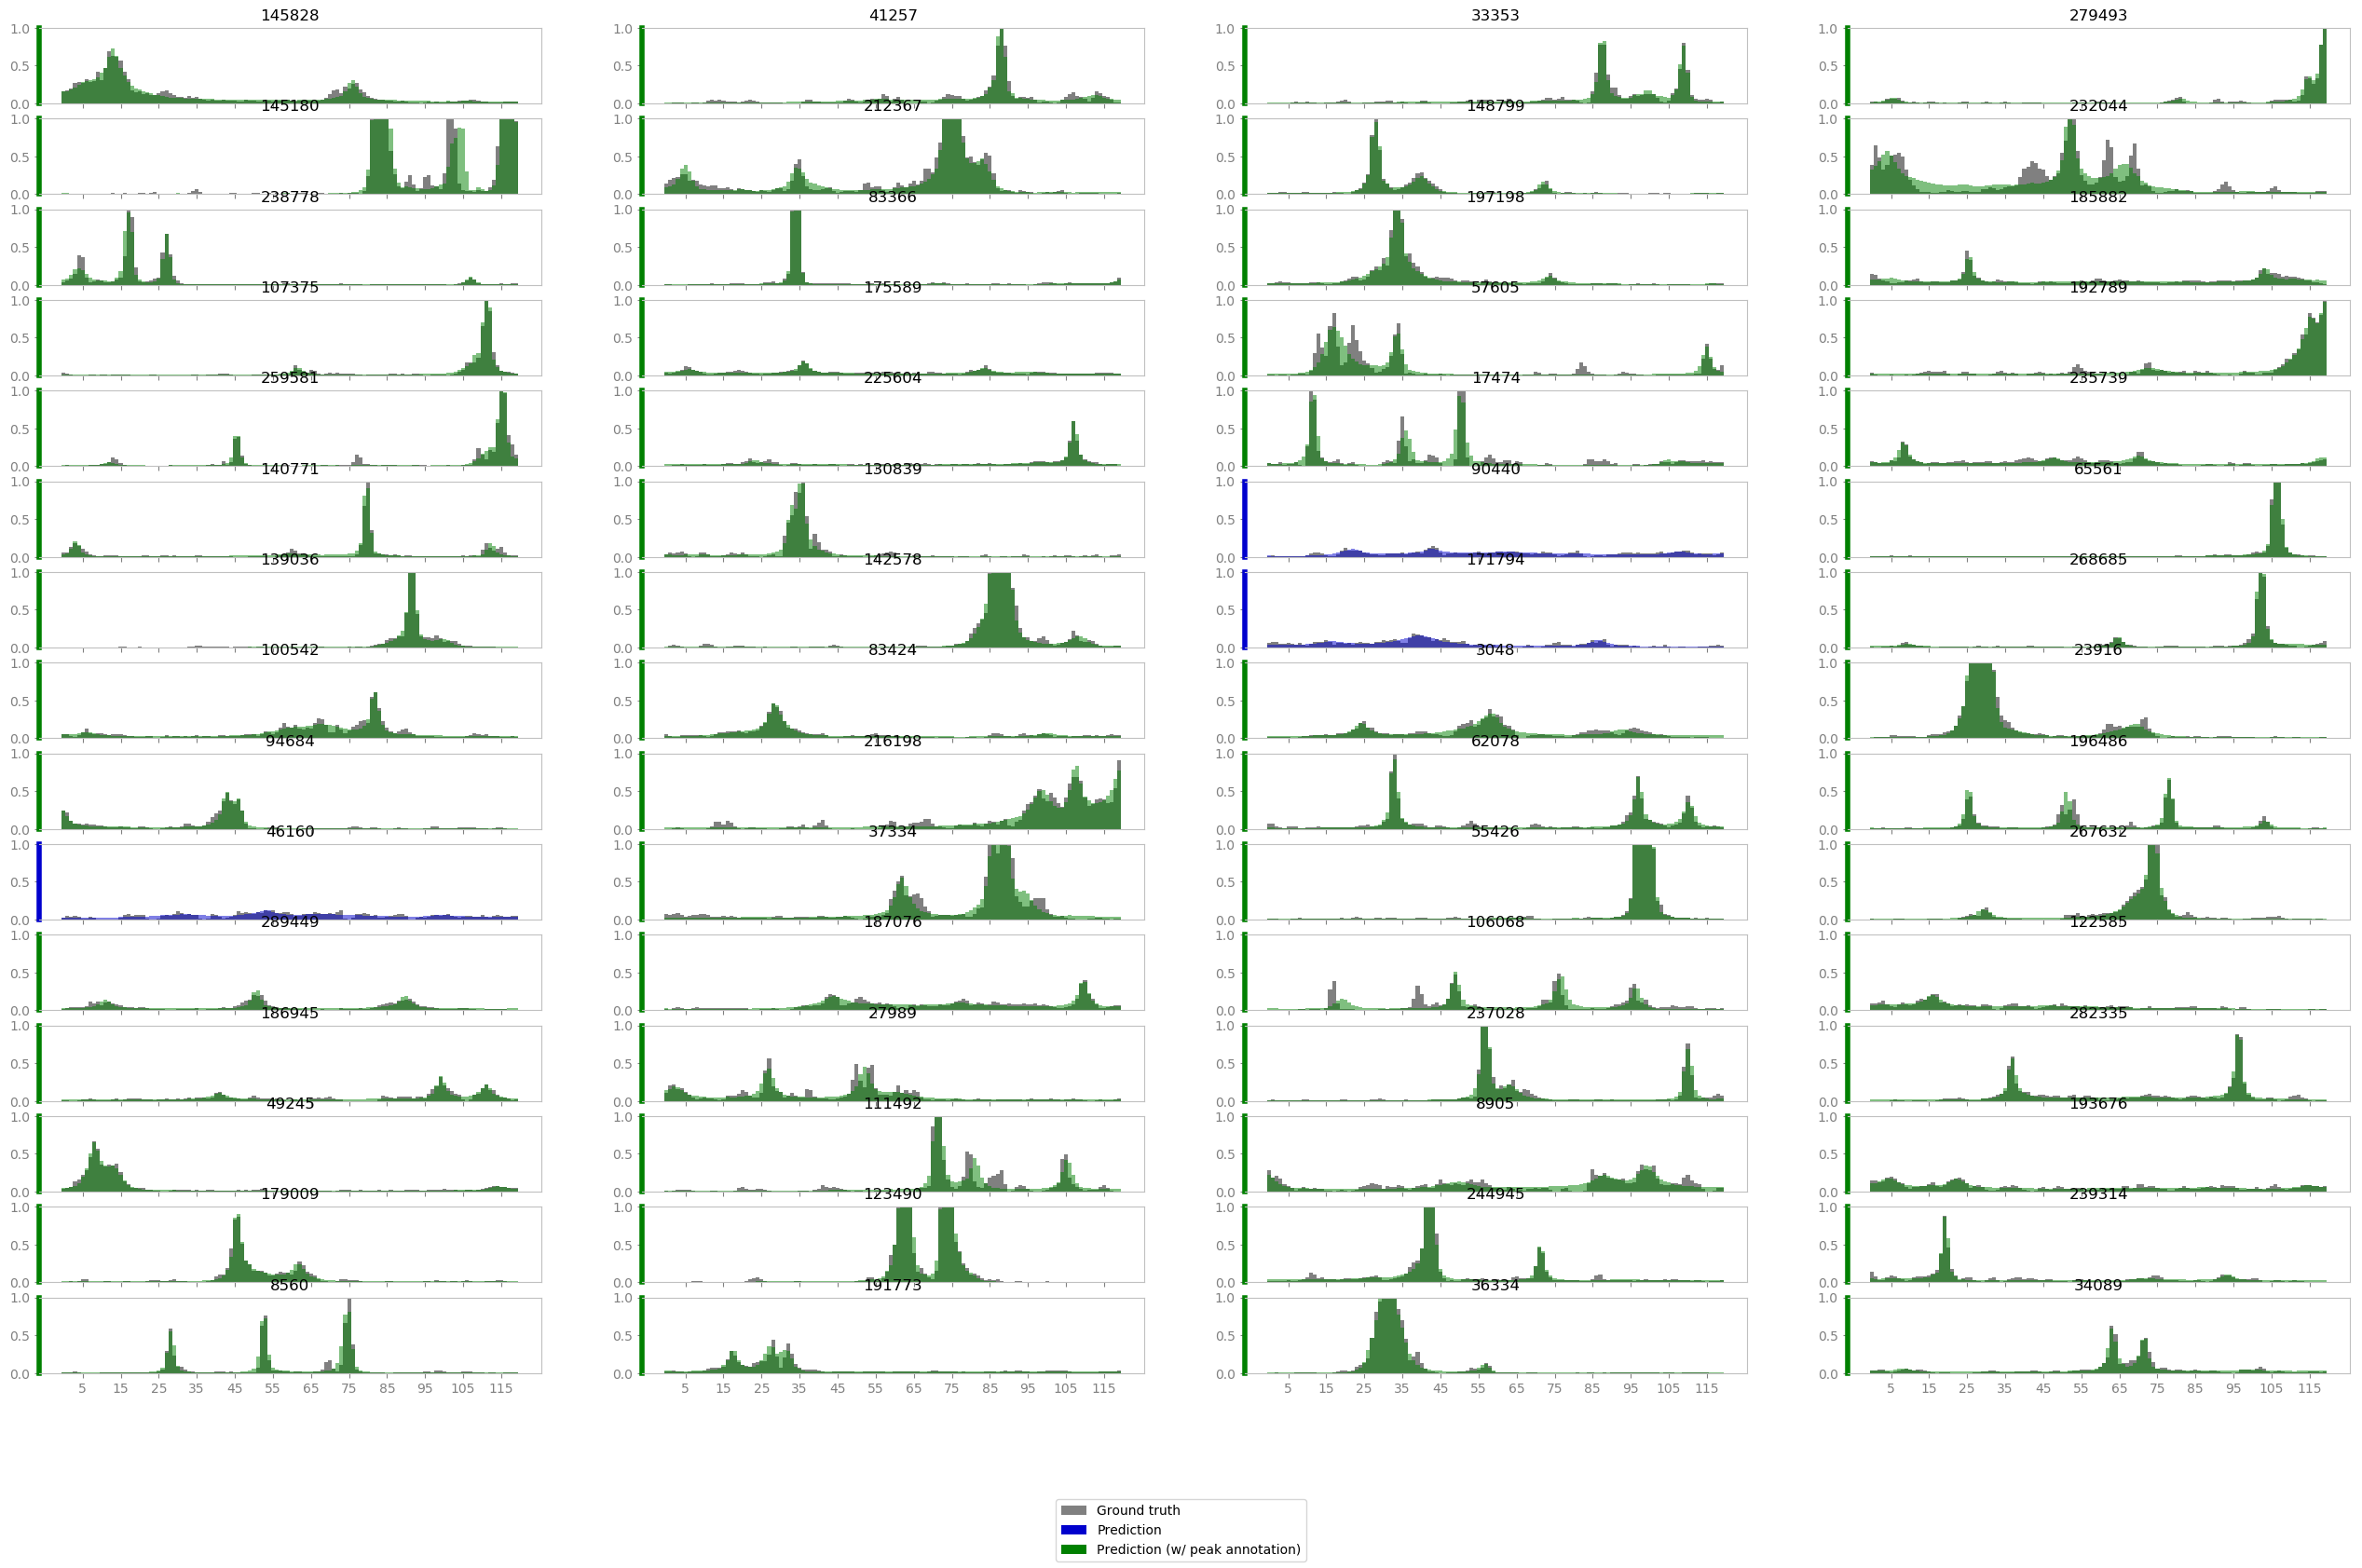

adam--lr-0.001--lrd-0.0--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0


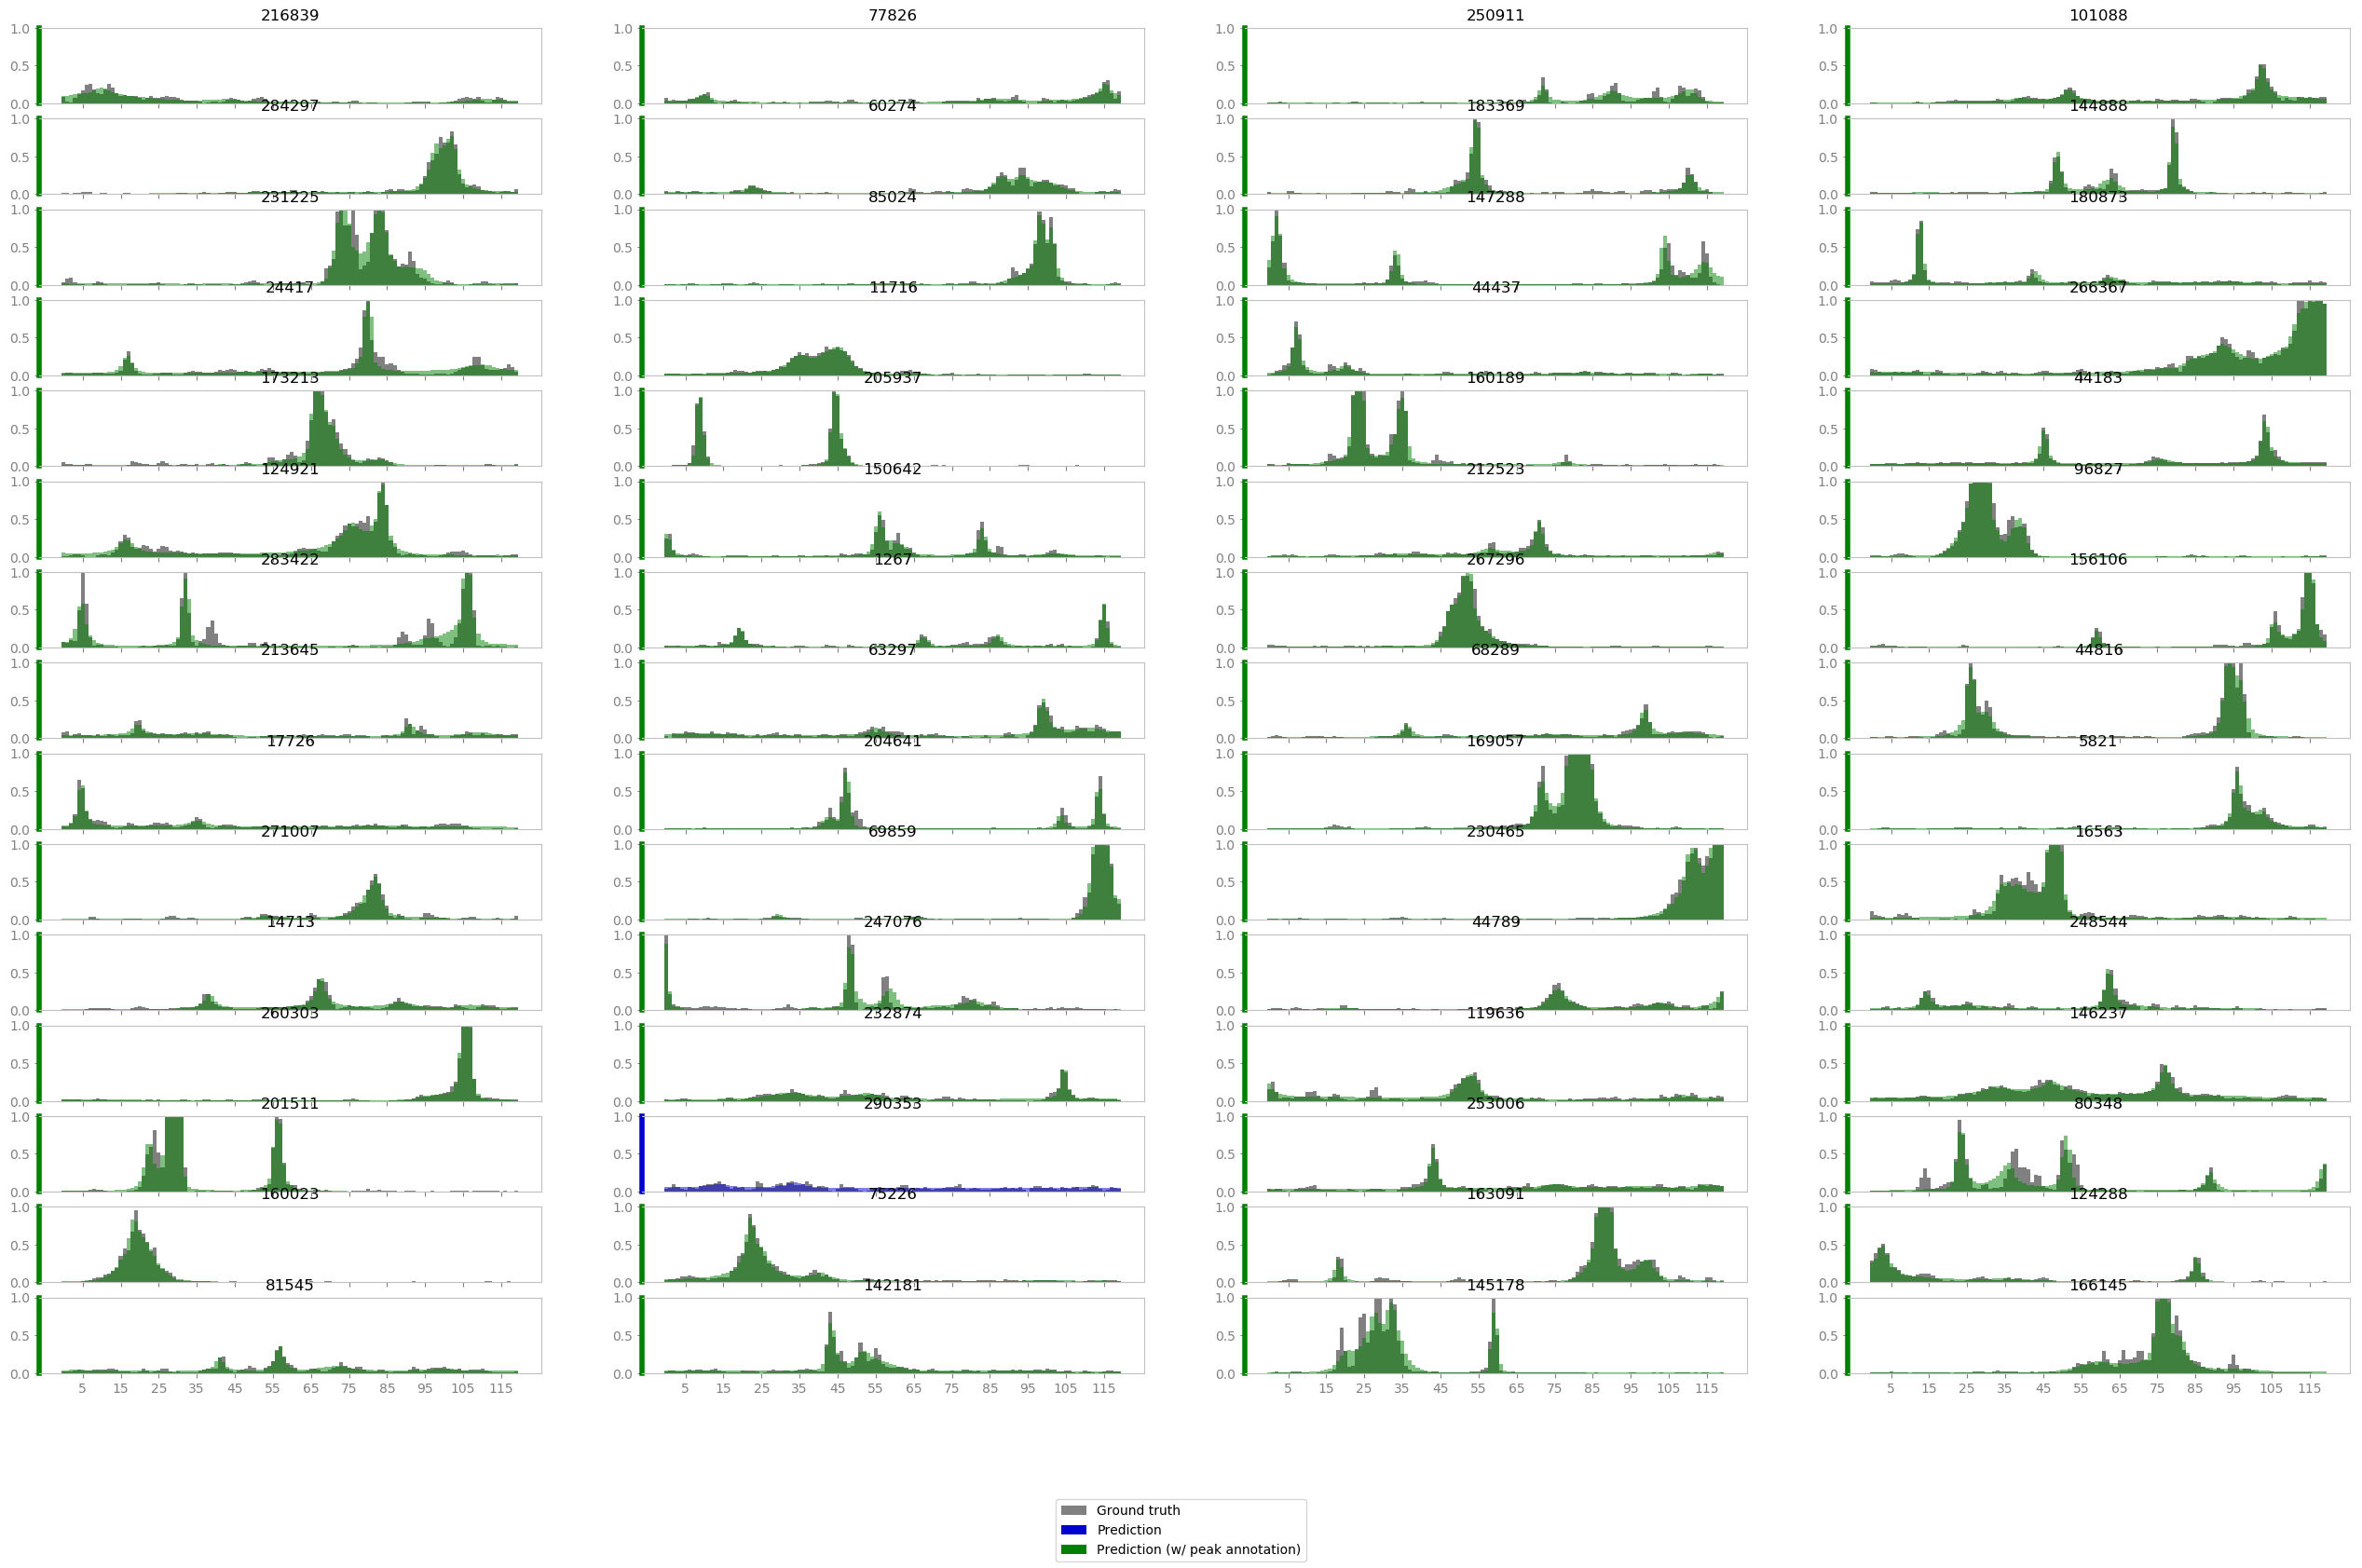

adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0


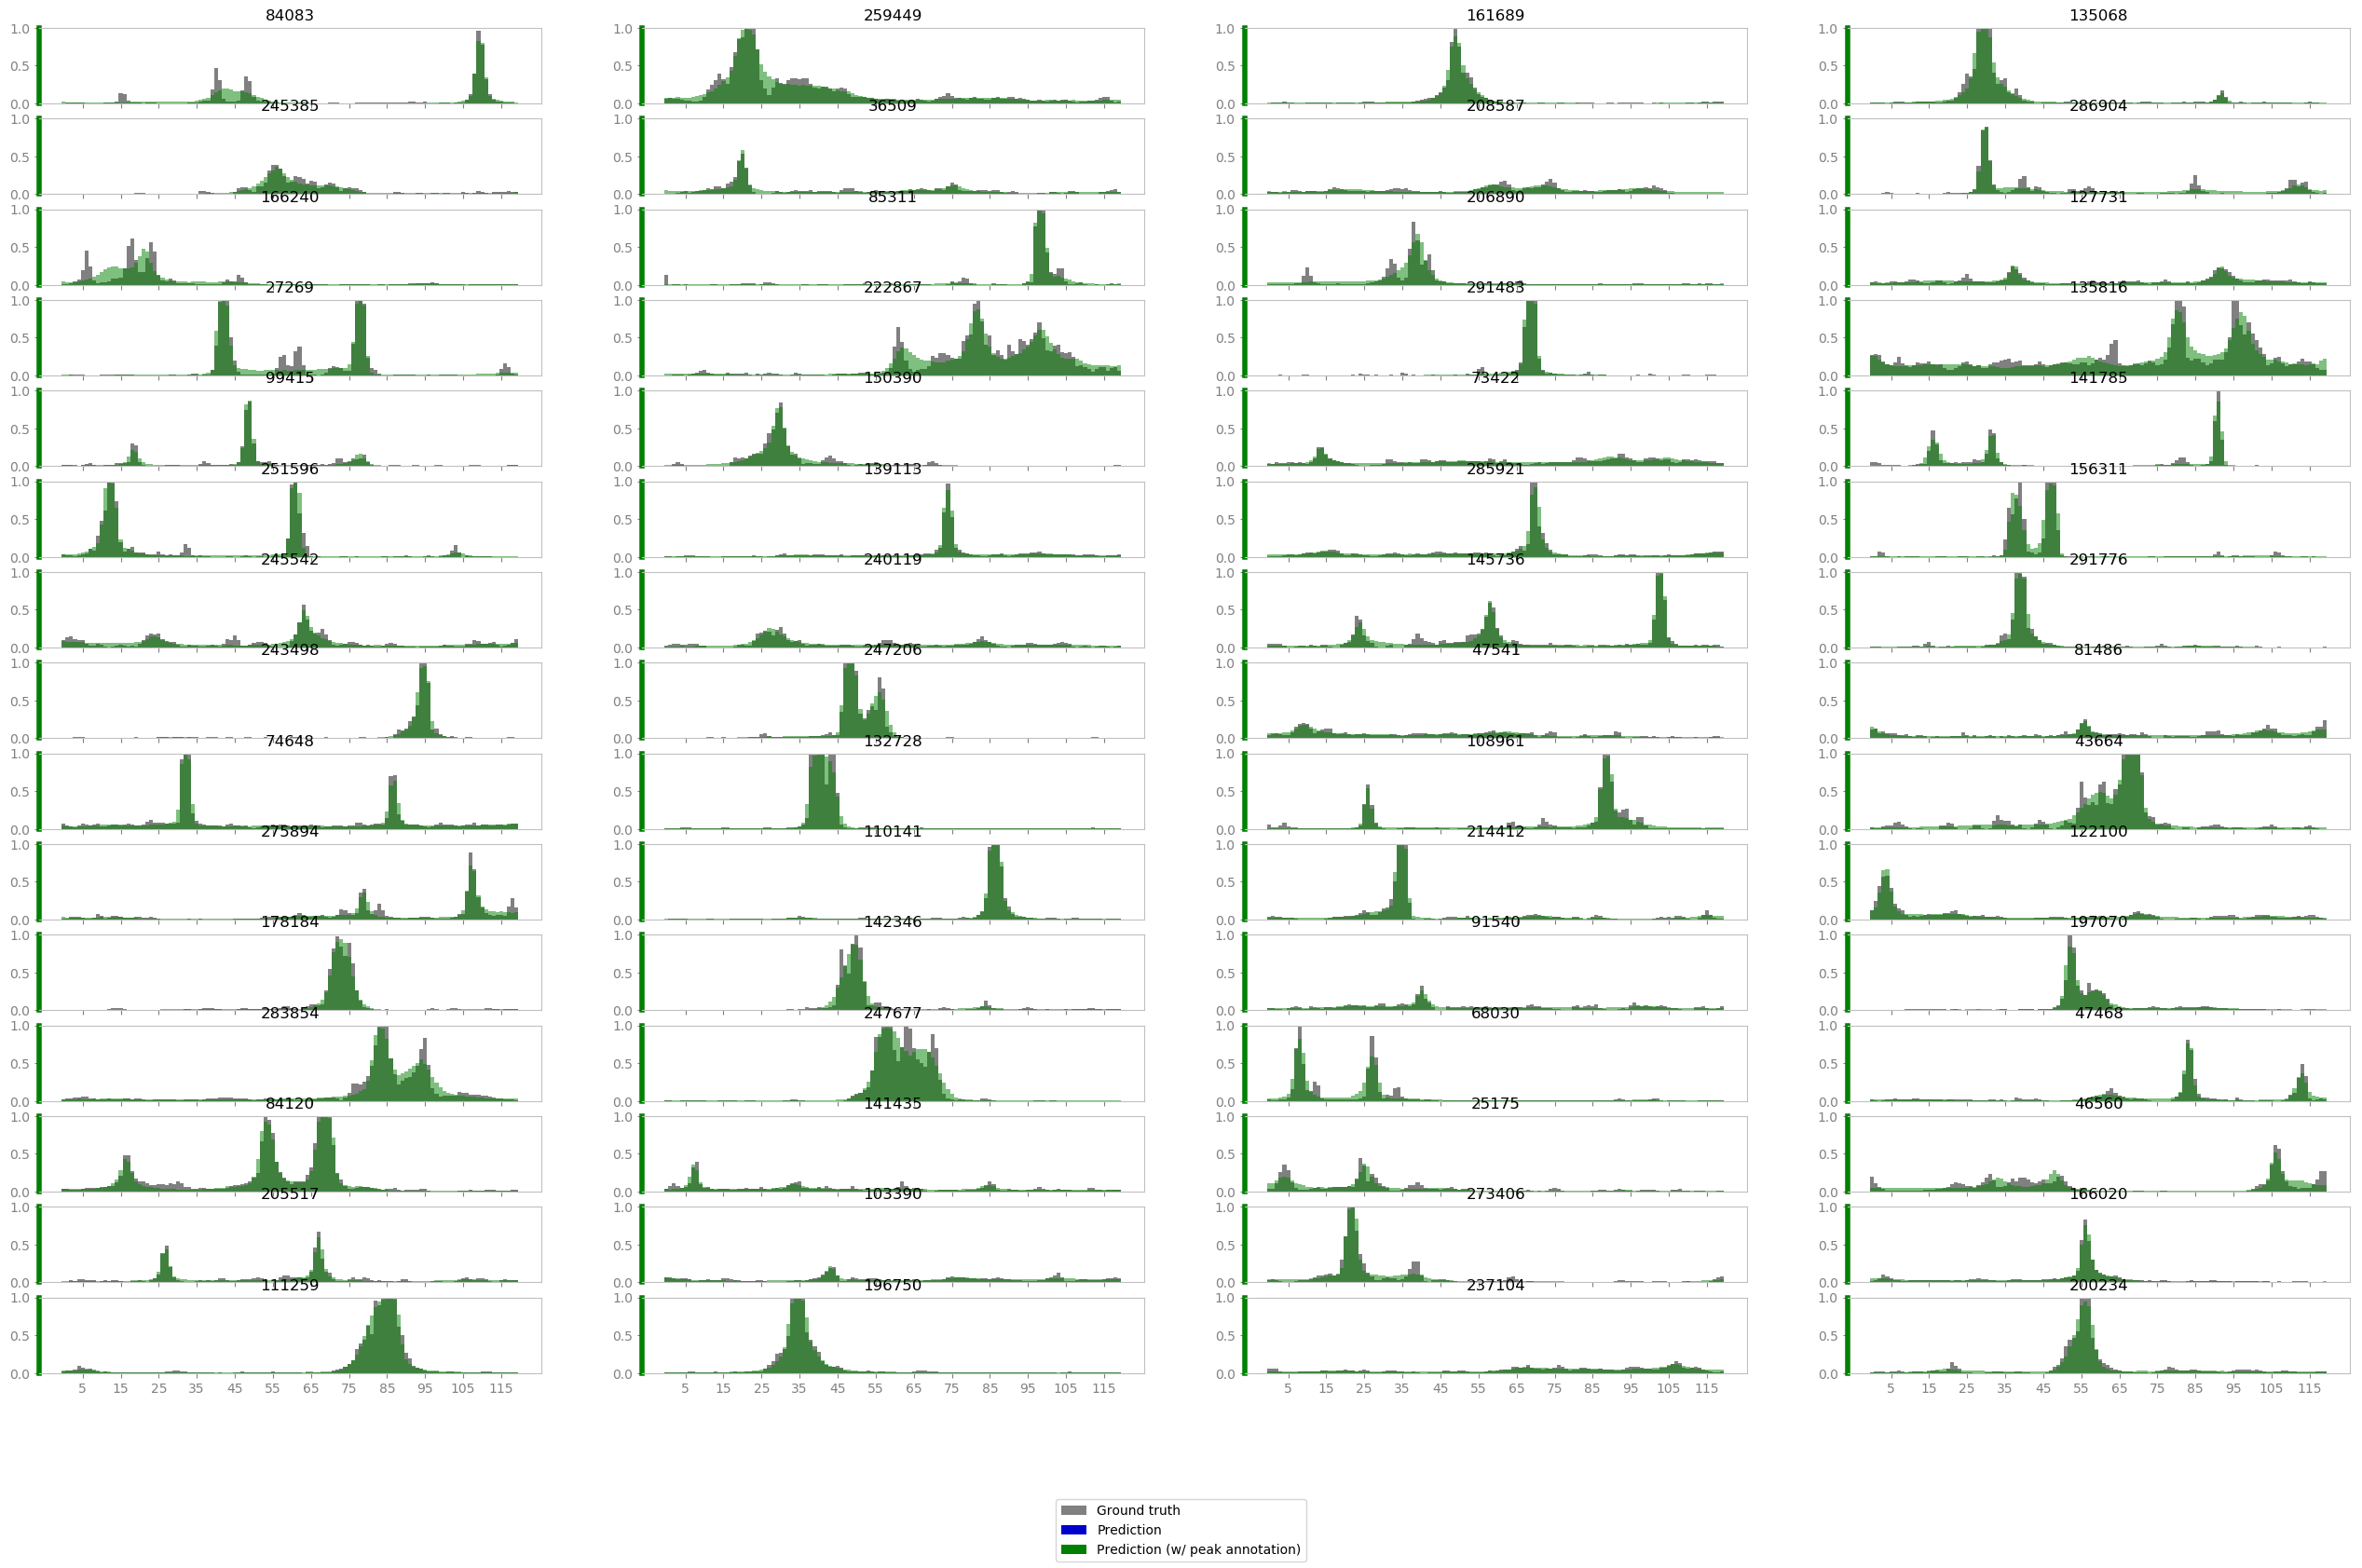

In [34]:
from IPython.core.display import Image, display

for model in qgw.get_selected_df().iterrows():
    repetition = None
    if len(model[0].split("__")) > 1:
        model_name, repetition = model[0].split("__")
    else:
        model_name = model[0]
        
    postfix = "-{}".format(dataset) if dataset is not None else ""
    postfix = "{}__{}".format(postfix, repetition) if repetition is not None else ""
        
    print(model_name)
        
    display(Image(os.path.join(base, 'models', 'cf-128-256-512-1024--ck-3-7-11-15--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-{}---predictions{}.png'.format(model_name, postfix))))